In [56]:
# !pip install google
# !pip install spacy
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

# Fetching Article

In [22]:
from nltk.util import everygrams
import re
import nltk
import pandas as pd
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
import urllib
# this function is to create bi-gram, tri-gram of words
def get_ngram(text):
    text = clean_text(text)
    n_grams = list(everygrams(text.split(), max_len=4))
    return [ ' '.join(grams) for grams in n_grams]

# this function fetches HTML file
def fetchHTMLdoc(link):
    site= link#"https://www.trustradius.com/information-technology"
    hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}

    req = urllib.request.Request(site, headers=hdr)

    try:
        page = urllib.request.urlopen(req)
    except urllib.error.HTTPError as e:
        print(e.fp.read())

    content = page.read()
    return(content)

#this function fetches title, text and link from HTML doc.
def fetchingTextFromHTML(html):
    soup = BeautifulSoup(html, features="html.parser")

    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out
    
    # get text
    title=soup.title.get_text()
    text = soup.body.get_text()
    links=[]
    for i in soup.find_all("a"):
        if i.get('href')!=None:
            if len(i.get('href'))> 7:
                links.append(i.get('href'))
    #m = re.search("\[\[Categorycategory:(.*)\]\]category",text)

    # # break into lines and remove leading and trailing space on each
    # lines = (line.strip() for line in text.splitlines())
    # # break multi-headlines into a line each
    # chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # # drop blank lines
    # text = '\n'.join(chunk for chunk in chunks if chunk)
    return title,text,links

# Searching for top Queries similar to User Query

In [47]:
#This function fetches top Queries similar to given queries and keywords related to it
def topQueriesWithLinks(query):
    from googlesearch import search 
    import wikipedia
    related_query=wikipedia.search(query,results=1)
    final_queries=[]
    final_queries+=related_query
    for i in related_query:
        final_queries+=wikipedia.search(i)

    list_of_links=[]
    for queries in final_queries:
        for j in search(queries, num=10, stop=10, pause=2): 
            list_of_links.append(j)
    return list(set(list_of_links)),final_queries

In [48]:
links,keywords=topQueriesWithLinks("How to do SEO")

In [50]:
htmls=[]
for i in links:
    htmls.append([fetchHTMLdoc(i),i])

In [164]:
#Code to store all relevant article in local system
# count=0
# for i in htmls:
#     count+=1
#     with open("article{}Files.html".format(count),"w") as f:
#         f.write(str(i))


# Storing relevant articles in json

In [54]:
list_of_articles=[]
count=0
for i in htmls:
    title,text,links=fetchingTextFromHTML(i[0])
    text=text.replace("\n","")
    list_of_articles.append({"title":title, "content":text,"link":i[1]})
    count+=1


# Fetching keywords from articles

In [57]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

## Removing Stopwords

In [58]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

# Corpus creation

In [60]:
corpus = []
for i in range(0, len(list_of_articles)):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', list_of_articles[i]["content"])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [61]:
corpus

['social medium optimizationfrom wikipedia free encyclopediathis latest accepted revision reviewed january jump navigationjump searchpart series oninternet marketingsearch engine optimizationlocal search engine optimisationsocial medium marketingemail marketingreferral marketingcontent marketingnative advertisingsearch engine marketingpay per clickcost per impressionsearch analyticsweb analyticsdisplay advertisingad blockingcontextual advertisingbehavioral targetingaffiliate marketingcost per actionrevenue sharingmobile advertisingvtesocial medium optimization smo use number outlet community generate publicity increase awareness product service brand event type social medium involved include r feed social news bookmarking site well social networking site facebook instagram twitter video sharing website blogging site smo similar search engine optimization goal generate web traffic increase awareness website general social medium optimization refers optimizing website content encourage u

## wordcloud to check most occuring words

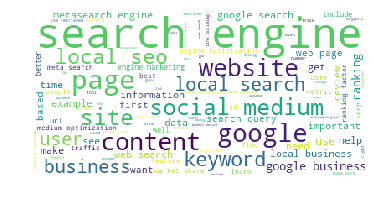

In [64]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=2000)

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [66]:
list(cv.vocabulary_.keys())[:10]


['social',
 'medium',
 'wikipedia',
 'free',
 'latest',
 'revision',
 'january',
 'jump',
 'navigationjump',
 'searchpart']

In [85]:
list_of_ngrams=[]

## Checking top ngrams words

[Text(0, 0, 'search'),
 Text(0, 0, 'engine'),
 Text(0, 0, 'google'),
 Text(0, 0, 'local'),
 Text(0, 0, 'page'),
 Text(0, 0, 'business'),
 Text(0, 0, 'seo'),
 Text(0, 0, 'result'),
 Text(0, 0, 'site'),
 Text(0, 0, 'content'),
 Text(0, 0, 'web'),
 Text(0, 0, 'website'),
 Text(0, 0, 'user'),
 Text(0, 0, 'link'),
 Text(0, 0, 'social'),
 Text(0, 0, 'medium'),
 Text(0, 0, 'marketing'),
 Text(0, 0, 'ranking'),
 Text(0, 0, 'information'),
 Text(0, 0, 'review')]

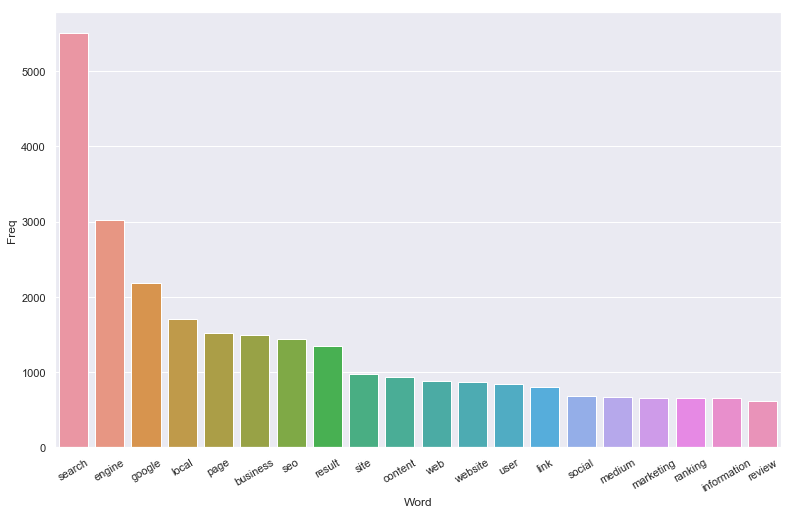

In [86]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
list_of_ngrams+=top_words
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                Bi-gram  Freq
0         search engine  2580
1         social medium   493
2         search result   453
3             local seo   432
4          local search   319
5       google business   257
6     metasearch engine   235
7         google search   182
8        local business   166
9            web search   159
10         search query   148
11             web page   148
12     engine marketing   147
13          result page   139
14        engine result   137
15  medium optimization   128
16  engine optimization   124
17          meta search   121
18       ranking factor   119
19         market share   111


[Text(0, 0, 'search engine'),
 Text(0, 0, 'social medium'),
 Text(0, 0, 'search result'),
 Text(0, 0, 'local seo'),
 Text(0, 0, 'local search'),
 Text(0, 0, 'google business'),
 Text(0, 0, 'metasearch engine'),
 Text(0, 0, 'google search'),
 Text(0, 0, 'local business'),
 Text(0, 0, 'web search'),
 Text(0, 0, 'search query'),
 Text(0, 0, 'web page'),
 Text(0, 0, 'engine marketing'),
 Text(0, 0, 'result page'),
 Text(0, 0, 'engine result'),
 Text(0, 0, 'medium optimization'),
 Text(0, 0, 'engine optimization'),
 Text(0, 0, 'meta search'),
 Text(0, 0, 'ranking factor'),
 Text(0, 0, 'market share')]

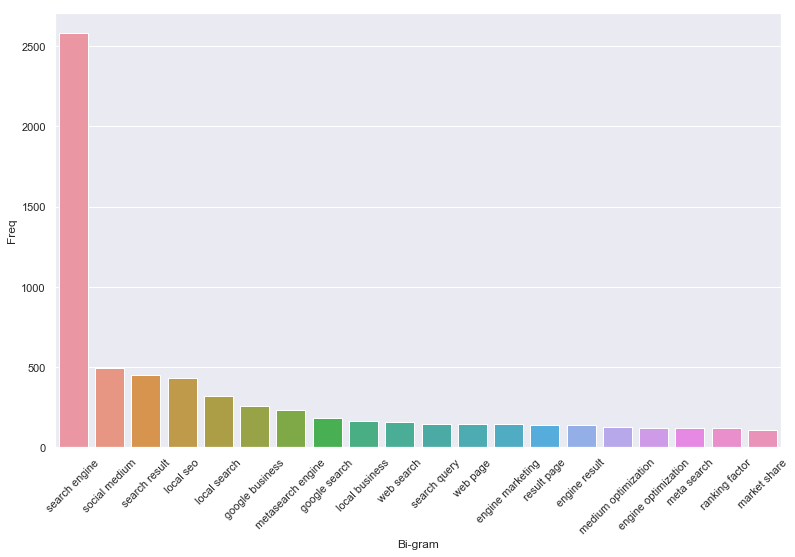

In [88]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
list_of_ngrams+=top2_words
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                       Tri-gram  Freq
0       search engine marketing   136
1          search engine result   123
2    search engine optimization   122
3    social medium optimization   120
4            meta search engine   107
5             web search engine    90
6            engine result page    75
7   director managerpaid search    70
8                 pay per click    68
9          search engine market    64
10         google search engine    62
11           watch mozcon video    52
12       internet search engine    51
13          major search engine    49
14         search engine search    47
15           search engine work    47
16               world wide web    44
17       social medium platform    43
18             term use privacy    41
19           search result page    40


[Text(0, 0, 'search engine marketing'),
 Text(0, 0, 'search engine result'),
 Text(0, 0, 'search engine optimization'),
 Text(0, 0, 'social medium optimization'),
 Text(0, 0, 'meta search engine'),
 Text(0, 0, 'web search engine'),
 Text(0, 0, 'engine result page'),
 Text(0, 0, 'director managerpaid search'),
 Text(0, 0, 'pay per click'),
 Text(0, 0, 'search engine market'),
 Text(0, 0, 'google search engine'),
 Text(0, 0, 'watch mozcon video'),
 Text(0, 0, 'internet search engine'),
 Text(0, 0, 'major search engine'),
 Text(0, 0, 'search engine search'),
 Text(0, 0, 'search engine work'),
 Text(0, 0, 'world wide web'),
 Text(0, 0, 'social medium platform'),
 Text(0, 0, 'term use privacy'),
 Text(0, 0, 'search result page')]

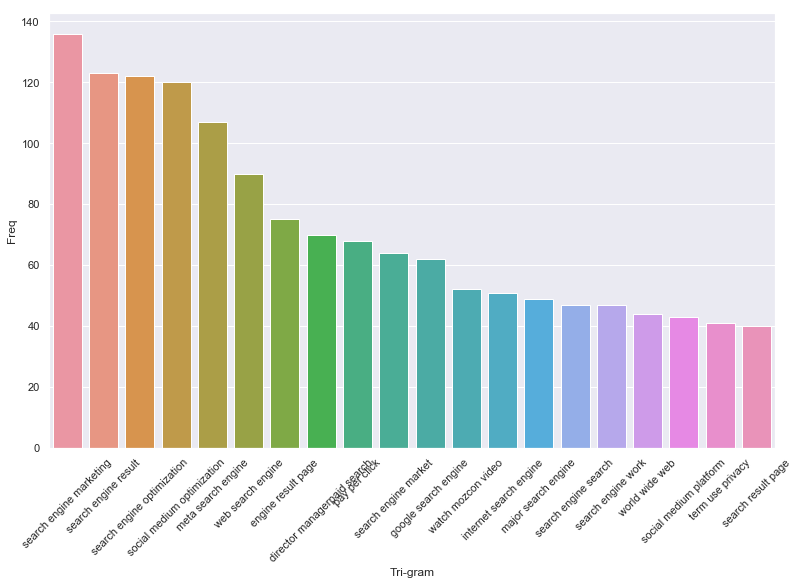

In [90]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
list_of_ngrams+=top3_words
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

## Using top N grams as feature

In [139]:
list_of_ngrams
feature_maker=[]
for i in list_of_ngrams:
    feature_maker.append(i[0])

    

## Using Tfidf transformer to convert word to vector

In [108]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(cv.fit_transform(feature_maker))
# get feature names
feature_names=cv.get_feature_names()
#print(feature_names)
# fetch document for which keywords needs to be extracted
doc=corpus[1]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

## Fetching Keywords from articles

In [109]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
skip contentseoall seoask seobeginner guide seocomplete guide seohow search engine workcomplete guide link buildinglocal seo guideon page seo guidetechnical seo guideseo auditppcall ppcppc guidedigital advertisingask ppc expertcontentall contentcontent marketing guidesocialall socialsocial medium guidefacebookinstagramlinkedinpinterestredditsnapchattwitteryoutubetiktoknewsall newsmost readadvertisemoresectionsseoppccontentsocial mediacareerfriday focusnewstopicsanalyticsdigital experienceinternational searchlink buildinglocal searchmobile searchtoolsweb developmentresourcessej esummite booksgoogle algorithm updatespodcastswebinarsjob boardsej merchadvertiseadvertising sejshopsejpost jobcompanysubscribeaboutcontactprivacy policydo sell infotoolboxpress materialsseo beginnersdownload youtubetwitterfacebookfollow usrsslinkedininstagramredditpinterestjob title agency manager directoranalytics manager professionalmarketing director managermarketing professionalseo director manage

## Model to fetch to 5 articles

In [131]:
def top_5_articles(list_of_articles):
    top_articles=[]
    count_container=[]
    for i in list_of_articles:
        count=0
        for j in feature_maker:
            count+=i["content"].count(j)
        if count not in count_container:
            top_articles.append([i,count])
            count_container.append(count)
            
    top_articles.sort(key = lambda x: x[1],reverse=True)
    return top_articles[0:5]

lists=top_5_articles(list_of_articles)


In [138]:
pprint(lists)

[[{'content': ' Features  Explore the BrightLocal platformLocal SEO ToolsTrack '
              'and improve local SEO performance  Local Search Rank '
              'CheckerCitation TrackerLocal Search AuditGoogle My Business '
              'AuditReputation ManagerManage and generate online reviews  Get '
              'ReviewsMonitor ReviewsShowcase ReviewsAgency FeaturesWow '
              'clients and grow your agency  Agency Lead '
              'GeneratorWhite-labelingBuild Citations  Ready to build '
              'citations?Let’s do itCitation BuilderBuild and fix citations '
              'quickly and cost-effectively  Local CitationsLocal Data '
              'AggregatorsYext Replacement ServiceSolutions  Case StudiesLearn '
              'how our customers have accelerated their success with '
              'BrightLocal.AgenciesWin and retain clients with white-label '
              'solutions.EnterpriseTake control of online visibility – for '
              'brands and agen

              'in Chapter 1, search engines are answer machines. They exist to '
              "discover, understand, and organize the internet's content in "
              'order to offer the most relevant results to the questions '
              'searchers are asking.In order to show up in search results, '
              "your content needs to first be visible to search engines. It's "
              'arguably the most important piece of the SEO puzzle: If your '
              "site can't be found, there's no way you'll ever show up in the "
              'SERPs (Search Engine Results Page).How do search engines '
              'work?Search engines work through three primary '
              'functions:Crawling: Scour the Internet for content, looking '
              'over the code/content for each URL they find.Indexing: Store '
              'and organize the content found during the crawling process. '
              'Once a page is in the index, it’s in the running to be '
         

              'Society. 16 (3): 169–185. CiteSeerX\xa010.1.1.24.8051. '
              'doi:10.1080/01972240050133634. S2CID\xa02111039.^ Hillis, Ken; '
              'Petit, Michael; Jarrett, Kylie (2012-10-12). Google and the '
              'Culture of Search. Routledge. ISBN\xa09781136933066.^ Reilly, '
              'P. (2008-01-01).  Spink, Prof Dr Amanda; Zimmer, Michael '
              "(eds.). 'Googling' Terrorists: Are Northern Irish Terrorists "
              'Visible on Internet Search Engines?. Information Science and '
              'Knowledge Management. 14. Springer Berlin Heidelberg. pp.\xa0'
              '151–175. Bibcode:2008wsis.book..151R. '
              'doi:10.1007/978-3-540-75829-7_10. ISBN\xa0978-3-540-75828-0. '
              'S2CID\xa084831583.^ Hiroko Tabuchi, "How Climate Change Deniers '
              'Rise to the Top in Google Searches", The New York Times, Dec. '
              '29, 2017. Retrieved November 14, 2018.^ Ballatore, A (2015). '
             

              '2013. Retrieved 2007-06-09.^ "Update to U.S. ad text trademark '
              'policy". adwords.blogspot.com. May 14, 2009. Retrieved '
              '2010-07-15.^ Rosso, Mark; Jansen, Bernard (Jim) (August 2010), '
              '"Brand Names as Keywords in Sponsored Search Advertising", '
              'Communications of the Association for Information Systems, 27 '
              '(1): 81–98, doi:10.17705/1CAIS.02706^ David O. Klein & Joshua '
              'R. Wueller, Trademark Enforcement and Internet Search '
              'Advertising: A Regulatory Risk for Brand Owners, IP Litigator, '
              'Nov./Dec. 2016.^ Google Inc (2007). "Google Adwords Case Study" '
              '(PDF). AccuraCast. Archived from the original (PDF) on 11 June '
              '2017. Retrieved 2011-03-30.^ a b c Zheng Xiang; Bing Pan; Rob '
              'Law & Daniel R. Fesenmaier (June 7, 2010). "Assessing the '
              'Visibility of Destination Marketing Organizations in 